# TinyML ECG Classification

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

## Read Dataset

In [2]:
df_train = pd.read_csv("/kaggle/input/heartbeat/mitbih_train.csv", header=None)
df_test = pd.read_csv("/kaggle/input/heartbeat/mitbih_test.csv", header=None)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# df[187] is y (class 0~4)
print(df_train[187].value_counts())
print(df_test[187].value_counts())

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64
0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: 187, dtype: int64


## Prepare Dataset

In [4]:
X_train = df_train.values[:, :-1]
y_train = df_train.values[:, -1].astype(int)

X_test  = df_test.values[:, :-1]
y_test  = df_test.values[:, -1].astype(int)

print(X_train.shape)
print(X_test.shape)

(87554, 187)
(21892, 187)


In [5]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1],1)

print(X_train.shape)
print(X_test.shape)

(87554, 1, 187, 1)
(21892, 1, 187, 1)


In [6]:
from tensorflow.keras import utils
y_train = utils.to_categorical(y_train)
y_test  = utils.to_categorical(y_test)

print(y_train.shape)
print(y_test.shape)

(87554, 5)
(21892, 5)


## Build Model

In [7]:
input_shape = X_train.shape[1:]
num_classes= 5

### *Conv1D not supported by TFLite for Micro, so Conv2D is used, not much difference in code size*

In [8]:
# Build Model 
from tensorflow.keras import models, layers

inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(16, kernel_size=5, activation='relu', padding='same')(inputs)
#x = layers.Conv2D(16, kernel_size=5, activation='relu', padding='same')(x)
#x = layers.MaxPooling2D((2,2), padding='same')(x)

x = layers.Flatten()(x)
x = layers.Dense(16)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 187, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 187, 16)        416       
_________________________________________________________________
flatten (Flatten)            (None, 2992)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                47888     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 85        
Total params: 48,389
Trainable params: 48,389
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train Model

In [10]:
batch_size = 100
num_epochs = 10 

In [11]:
# Train Model
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/10
876/876 [==============================] - 8s 9ms/step - loss: 0.3378 - accuracy: 0.9045 - val_loss: 0.2184 - val_accuracy: 0.9417
Epoch 2/10
876/876 [==============================] - 8s 9ms/step - loss: 0.1795 - accuracy: 0.9521 - val_loss: 0.1713 - val_accuracy: 0.9553
Epoch 3/10
876/876 [==============================] - 8s 9ms/step - loss: 0.1546 - accuracy: 0.9580 - val_loss: 0.1575 - val_accuracy: 0.9587
Epoch 4/10
876/876 [==============================] - 8s 9ms/step - loss: 0.1438 - accuracy: 0.9609 - val_loss: 0.1607 - val_accuracy: 0.9565
Epoch 5/10
876/876 [==============================] - 8s 9ms/step - loss: 0.1367 - accuracy: 0.9625 - val_loss: 0.1628 - val_accuracy: 0.9556
Epoch 6/10
876/876 [==============================] - 7s 9ms/step - loss: 0.1300 - accuracy: 0.9644 - val_loss: 0.1460 - val_accuracy: 0.9615
Epoch 7/10
876/876 [==============================] - 8s 9ms/step - loss: 0.1261 - accuracy: 0.9654 - val_loss: 0.1377 - val_accuracy: 0.9627
Epoch 

## Save Model

In [12]:
# Save Model
models.save_model(model, 'ecg_arrhythmia.hdf5')

## TinyML

In [13]:
!pip install tinymlgen

  Created wheel for tinymlgen: filename=tinymlgen-0.2-py3-none-any.whl size=2243 sha256=e34d75e81d2ba7467cc720a0d2c045e7751118fa4d33a071abd0d76569b6b958
  Stored in directory: /root/.cache/pip/wheels/1c/94/c7/a18049eea10532c9975ad7353fcccc7c436673285b4723a4bb
  Created wheel for hexdump: filename=hexdump-3.3-py3-none-any.whl size=8911 sha256=541121546b04ae9dbf42b7c44b76b88278cbe2c0ec0a7b0af0e506491737a49e
  Stored in directory: /root/.cache/pip/wheels/68/fe/aa/06fd9d6968cfc3e1926eeab1ec728c246dafa120a72ff9afae
Successfully built tinymlgen hexdump
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


### export model
    import tensorflow as tf
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Save the model to disk
    open("ecg_arrhythmia.tflite", "wb").write(tflite_model)
    
    # hex dump
    !xxd -i ecg_arrhythmia.tflite > ecg_arrhythmia.cc

In [14]:
from tinymlgen import port
c_code = port(model, variable_name='ecg_arrhythmia', pretty_print=True, optimize=False) 

with open('ecg_arrhythmia.h', 'w') as f:
    print(c_code, file=f)

### export a test data

In [15]:
with open('x_test.h', 'w') as f:
    print("float x_test_dat[187] = {", file=f)    
    s="    "
    for i in range(187):
        s+=str(X_test[0][0][i][0])+', '
        if i==186:
            print(s, file=f) 
        elif (i+1)%8==0:
            print(s, file=f)
            s="    "
    print("};", file=f)
f.close()

In [16]:
!cat x_test.h

float x_test_dat[187] = {
    1.0, 0.7582644820213318, 0.11157024651765823, 0.0, 0.08057851344347002, 0.07851240038871765, 0.06611569970846176, 0.04958677664399147, 
    0.047520659863948815, 0.03512396663427353, 0.03099173493683338, 0.028925620019435883, 0.03512396663427353, 0.026859503239393234, 0.039256200194358826, 0.03512396663427353, 
    0.043388430029153824, 0.047520659863948815, 0.05371900647878647, 0.05371900647878647, 0.07024793326854706, 0.0723140463232994, 0.08471074700355531, 0.09710744023323059, 
    0.12190082669258115, 0.13223139941692352, 0.1694214940071106, 0.19628098607063293, 0.2148760259151459, 0.23553718626499176, 0.2541322410106659, 0.26446279883384705, 
    0.2851239740848541, 0.27272728085517883, 0.2665289342403412, 0.23966942727565765, 0.2148760259151459, 0.1735537201166153, 0.1570248007774353, 0.12396693974733353, 
    0.12190082669258115, 0.10743801295757292, 0.10537189990282057, 0.09710744023323059, 0.10537189990282057, 0.09917355328798294, 0.1053718999028

In [17]:
print(y_test[0])

[1. 0. 0. 0. 0.]


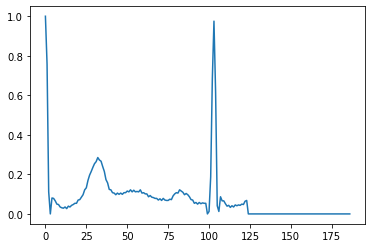

In [18]:
plt.plot(X_test[0][0])